In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

data1 = pd.read_csv('b30hz0.txt', sep="\t", header=None)
data2 = pd.read_csv('h30hz0.txt', sep="\t", header=None)

data1.rename(columns={0: "s1", 1: "s2", 2: "s3", 3: "s4"}, inplace=True)
data1.drop(columns=[4], inplace=True)

data2.rename(columns={0: "s1", 1: "s2", 2: "s3", 3: "s4"}, inplace=True)
data2.drop(columns=[4], inplace=True)


<Axes: >

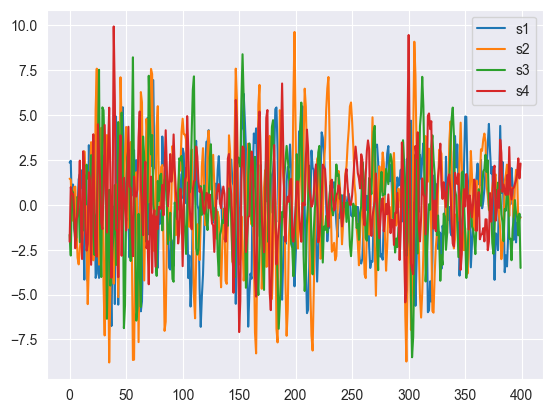

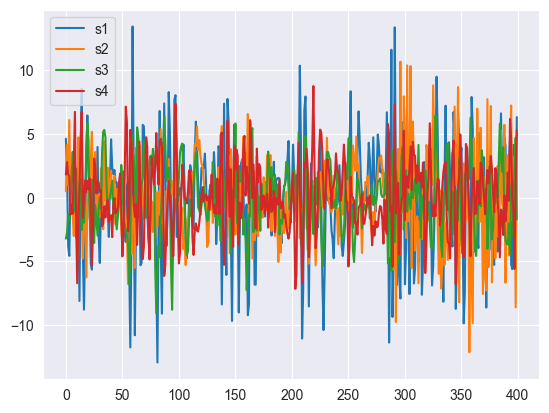

In [2]:
start_idx = 0
end_idx = 400

data1 = data1[start_idx:end_idx]
data2 = data2[start_idx:end_idx]

data1.plot()
data2.plot()


### Корреляция сигналов из набора Data1

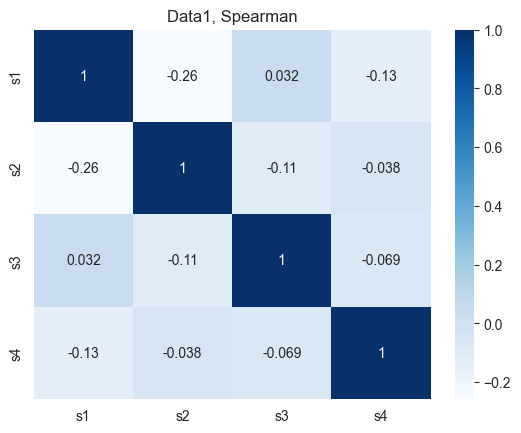

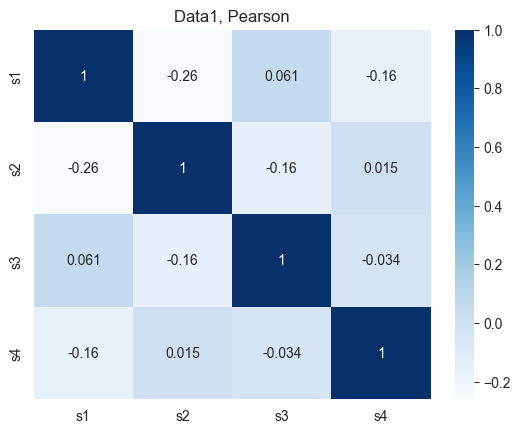

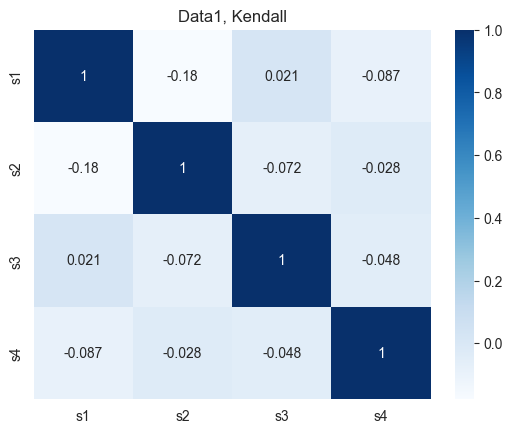

In [3]:
#Корреляция Спирмена
c = data1.corr(method="spearman")
sns.heatmap(c, annot=True, cmap='Blues')
plt.title('Data1, Spearman')
plt.show()
#Корреляция Пирсона
c = data1.corr(method="pearson")
sns.heatmap(c, annot=True, cmap='Blues')
plt.title('Data1, Pearson')
plt.show()
#Корреляция Кенделла
c = data1.corr(method="kendall")
sns.heatmap(c, annot=True, cmap='Blues')
plt.title('Data1, Kendall')
plt.show()

Корреляция Пирсона: лучше всего подходит для линейных зависимостей с нормально распределенными данными.

Корреляция Спирмена: подходит для монотонных зависимостей и не требует нормальности.

Корреляция Кендалла: часто используется для небольших выборок и данных с большим количеством одинаковых значений.

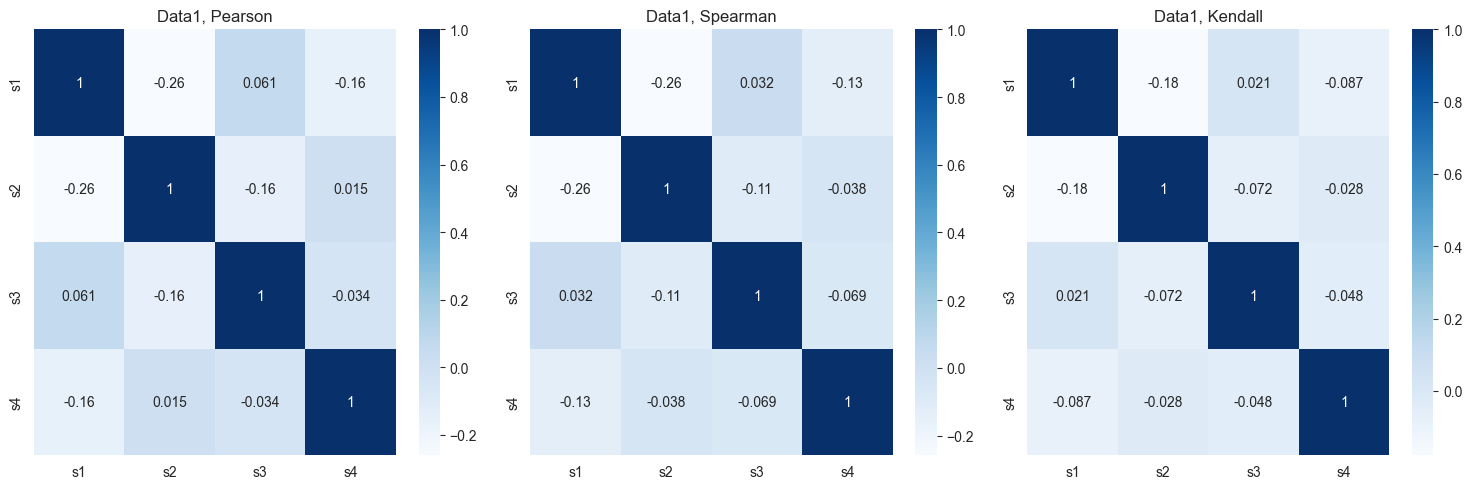

In [4]:
from scipy.stats import rankdata  # Импорт функции rankdata


# Функция для расчета корреляции Пирсона
def pearson_corr(x, y):
    return np.corrcoef(x, y)[0, 1]


# Функция для расчета корреляции Спирмена
def spearman_corr(x, y):
    return pearson_corr(rankdata(x), rankdata(y))


# Функция для расчета корреляции Кендалла
def kendall_corr(x, y):
    n = len(x)
    ties_x = np.array([np.sum(x == x[i]) for i in range(n)])
    ties_y = np.array([np.sum(y == y[i]) for i in range(n)])
    num_ties = np.sum(ties_x * (ties_x - 1) // 2) + np.sum(
        ties_y * (ties_y - 1) // 2)
    concordant = 0
    discordant = 0

    for i in range(n):
        for j in range(i + 1, n):
            if (x[i] - x[j]) * (y[i] - y[j]) > 0:
                concordant += 1
            elif (x[i] - x[j]) * (y[i] - y[j]) < 0:
                discordant += 1

    return (concordant - discordant) / (0.5 * n * (n - 1) - num_ties)


# Создание матриц корреляции
pearson_matrix = pd.DataFrame(index=data1.columns, columns=data1.columns)
spearman_matrix = pd.DataFrame(index=data1.columns, columns=data1.columns)
kendall_matrix = pd.DataFrame(index=data1.columns, columns=data1.columns)

# Заполнение матриц
for i in data1.columns:
    for j in data1.columns:
        pearson_matrix.loc[i, j] = pearson_corr(data1[i], data1[j])
        spearman_matrix.loc[i, j] = spearman_corr(data1[i], data1[j])
        kendall_matrix.loc[i, j] = kendall_corr(data1[i], data1[j])

# Визуализация
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.heatmap(pearson_matrix.astype(float), annot=True, cmap='Blues', cbar=True)
plt.title('Data1, Pearson')

plt.subplot(1, 3, 2)
sns.heatmap(spearman_matrix.astype(float), annot=True, cmap='Blues', cbar=True)
plt.title('Data1, Spearman')

plt.subplot(1, 3, 3)
sns.heatmap(kendall_matrix.astype(float), annot=True, cmap='Blues', cbar=True)
plt.title('Data1, Kendall')

plt.tight_layout()
plt.show()

### Корреляция между сигналоми наборов Data1 и Data2

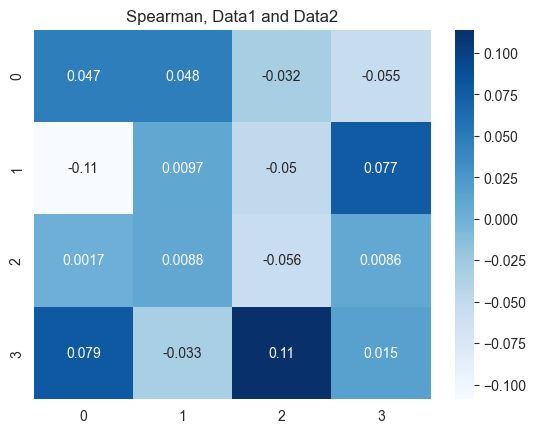

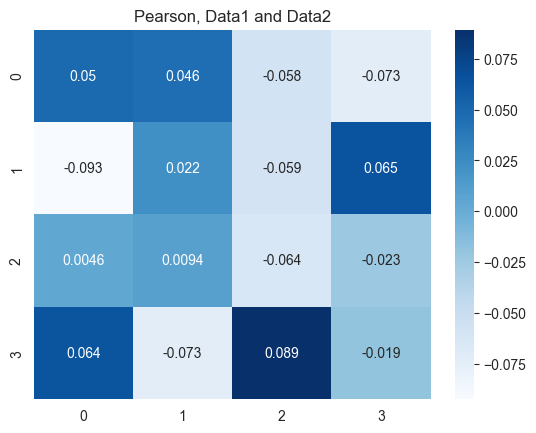

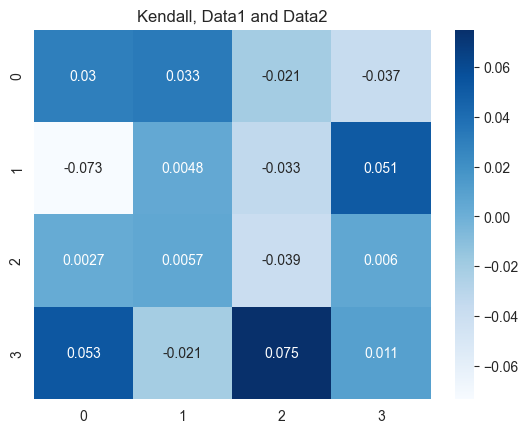

In [5]:
# Сравнение корреляций между data1 и data2
# Корреляция Спирмена
corr_res = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        query = data2.iloc[:, i].to_numpy()
        template = data1.iloc[:, j].to_numpy()
        corr_res[i, j] = spearman_corr(query, template)

sns.heatmap(corr_res, annot=True, cmap='Blues')
plt.title('Spearman, Data1 and Data2')
plt.show()

# Корреляция Пирсона
corr_res = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        query = data2.iloc[:, i].to_numpy()
        template = data1.iloc[:, j].to_numpy()
        corr_res[i, j] = pearson_corr(query, template)

sns.heatmap(corr_res, annot=True, cmap='Blues')
plt.title('Pearson, Data1 and Data2')
plt.show()

# Корреляция Кендалла
corr_res = np.zeros((4, 4))
for i in range(4):
    for j in range(4):
        query = data2.iloc[:, i].to_numpy()
        template = data1.iloc[:, j].to_numpy()
        corr_res[i, j] = kendall_corr(query, template)

sns.heatmap(corr_res, annot=True, cmap='Blues')
plt.title('Kendall, Data1 and Data2')
plt.show()

### Dynamic time warpring - пример

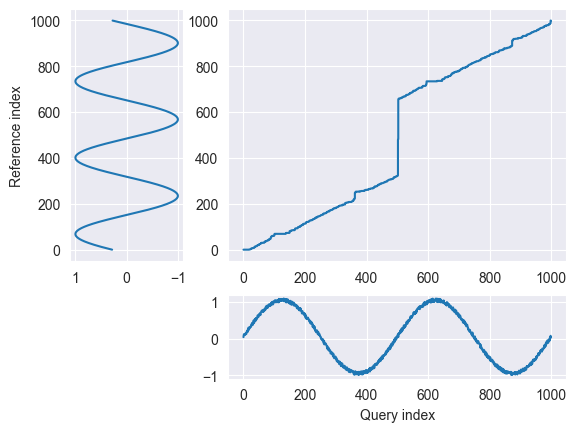

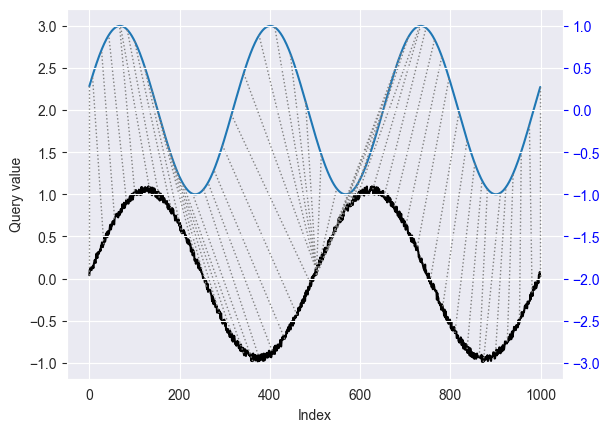

In [10]:
import numpy as np
#from dtw import dtwPlot
from dtw import *
from scipy.spatial.distance import euclidean
#from fastdtw import fastdtw

idx = np.linspace(0, 6.28, num=1000)
# заушмленная синусоидальная волна
query = np.sin(idx * 2) + np.random.uniform(size=1000) / 10.0

# создает косинусоиду, изменяя частоту на 3 и добавляя сдвиг фазы на 5 радианов
template = np.cos(idx * 3 + 5)

# оптимальное выравнивание между временными рядами, 
# которые могут быть смещены по времени или имеют различную скорость
alignment = dtw(query, template, keep_internals=True)



alignment.plot(type="threeway")
alignment.plot(type="twoway", offset=2)

plt.show()  # Показываем графики

### Расчет дистанции с помощью DTW 

In [11]:
dtw_dist_norm = alignment.normalizedDistance
dtw_dist = alignment.distance
print(dtw_dist, dtw_dist_norm)

230.11696029857944 0.11505848014928972


### DTW дистанции между сигналами набора Data1 

Text(0.5, 1.0, 'DTW С нормализацияей, Data1')

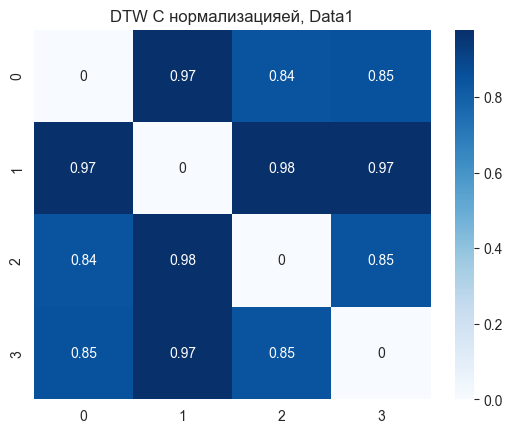

In [12]:
#Нормализованные расстояния DTW
dtw_res = np.zeros([4, 4])
for i in [0, 1, 2, 3]:
    for j in [0, 1, 2, 3]:
        query = data1.iloc[:, [i]].to_numpy()
        template = data1.iloc[:, [j]].to_numpy()
        alignment = dtw(query, template, keep_internals=True)
        dtw_res[i, j] = alignment.normalizedDistance
sns.heatmap(dtw_res, annot=True, cmap='Blues')
plt.title('DTW С нормализацияей, Data1')

Text(0.5, 1.0, 'DTW С нормализацияей, Data2')

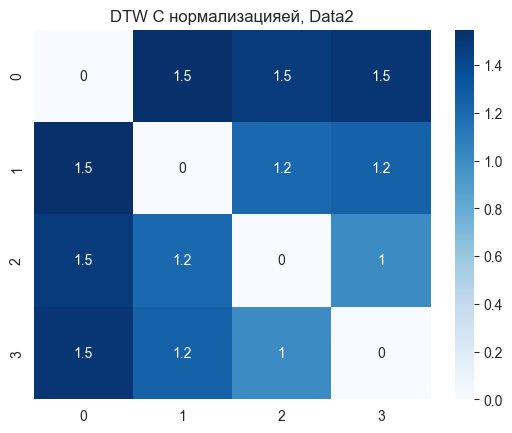

In [13]:
#Нормализованные расстояния DTW
dtw_res = np.zeros([4, 4])
for i in [0, 1, 2, 3]:
    for j in [0, 1, 2, 3]:
        query = data2.iloc[:, [i]].to_numpy()
        template = data2.iloc[:, [j]].to_numpy()
        alignment = dtw(query, template, keep_internals=True)
        dtw_res[i, j] = alignment.normalizedDistance
sns.heatmap(dtw_res, annot=True, cmap='Blues')
plt.title('DTW С нормализацияей, Data2')

### DTW дистанции между сигналами Data1 и Data2

Text(0.5, 1.0, 'Signal DTW normalized distances, Data2')

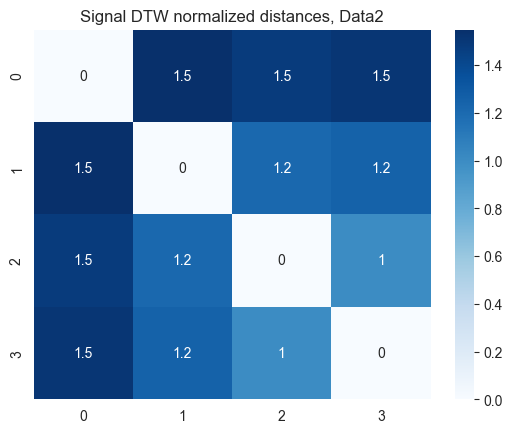

In [14]:
#Нормализованные расстояния DTW
dtw_res = np.zeros([4, 4])
for i in [0, 1, 2, 3]:
    for j in [0, 1, 2, 3]:
        query = data2.iloc[:, [i]].to_numpy()
        template = data2.iloc[:, [j]].to_numpy()
        alignment = dtw(query, template, keep_internals=True)
        dtw_res[i, j] = alignment.normalizedDistance
sns.heatmap(dtw_res, annot=True, cmap='Blues')
plt.title('Signal DTW normalized distances, Data2')

### Спектральная плотность мощности сигнала

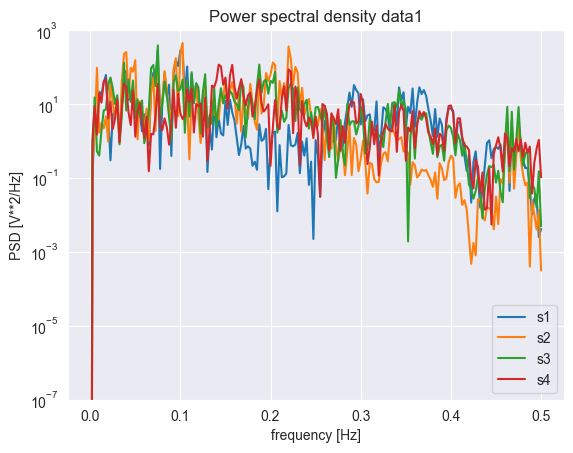

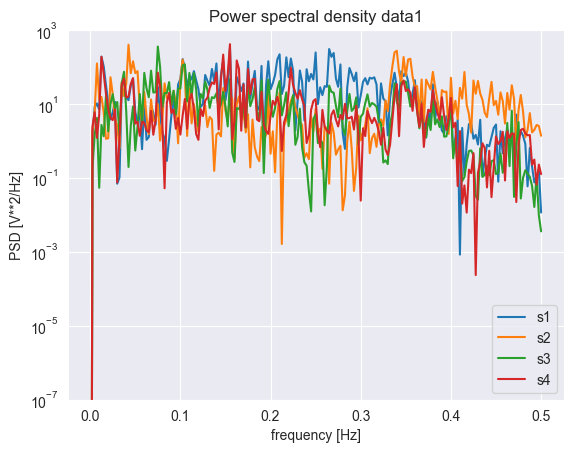

In [15]:
#Периодограмма
from scipy import signal

for i in [0, 1, 2, 3]:
    data = data1.iloc[:, [i]].to_numpy().reshape(400)
    f, Pxx_den = signal.periodogram(data, 1)
    plt.semilogy(f, Pxx_den)
    plt.ylim([1e-7, 1e3])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend(['s1', 's2', 's3', 's4'])
    plt.title('Power spectral density data1')
plt.show()

from scipy import signal

for i in [0, 1, 2, 3]:
    data = data2.iloc[:, [i]].to_numpy().reshape(400)
    f, Pxx_den = signal.periodogram(data, 1)
    plt.semilogy(f, Pxx_den)
    plt.ylim([1e-7, 1e3])
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend(['s1', 's2', 's3', 's4'])
    plt.title('Power spectral density data1')
plt.show()

### Декомпозиция сигнала

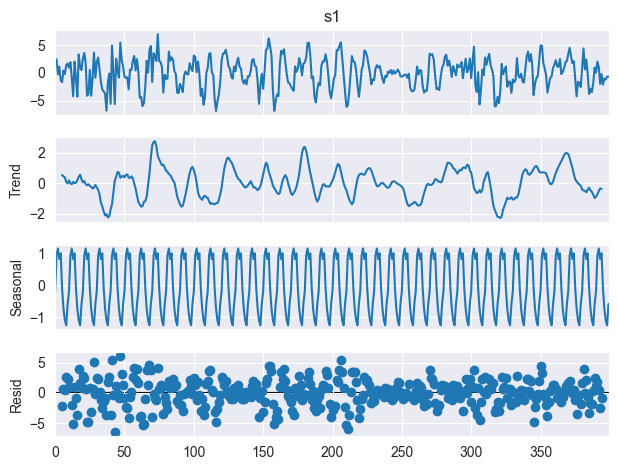

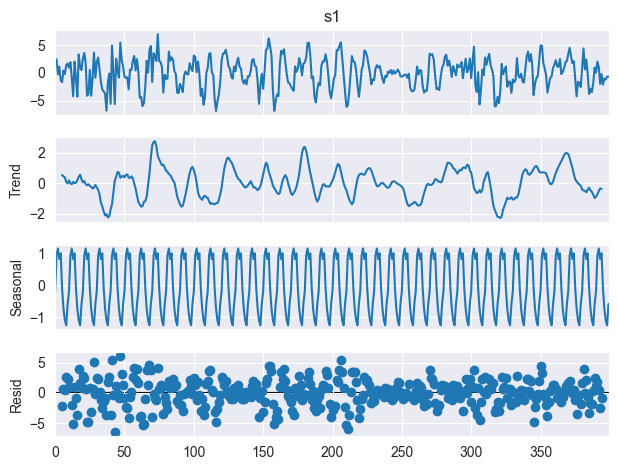

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(data1.s1, model='additive', period=10).plot()


# Задание
Сравнить временные ряды (варианты по методам и наборам данных) с эталонным сигналом и идентифицировать состояние (ЭКГ, работа мотора автомобиля,
идентификация состояния оборудования). 
* Взять не менее 100 значений
* Посчитать для всех сочетаний значения коэффициентов корреляции (Пирсона, Спирмена, Кендала) и сделать соответствующие выводы. 
* Посчитать значение DTW для всех сочетаний, сравнить со значениями коэффициентов корреляции, сделать выводы. 
* Посчитать спектральную плотность сигнала. Разложить временные ряды на составляющие.
### Данные для примера
* h… - нормативная работа подшипника (сигналы с четырех датчиков вибрации)
* b… - не нормативная работа подшипника (сигналы с четырех датчиков вибрации)